I have had an Atmotube Pro for [a few years](/posts/indoor_air_quality/), mostly using it during the summer to keep an eye on poor air quality during wildfire smoke events. I often export data from it, as a csv, to noodle around, but I haven't really looked at how to log data directly from it with my laptop. Atmotube provides documentation on [the bluetooth API](https://support.atmotube.com/en/articles/10364981-bluetooth-api) and a guide for how to set up an [MQTT router](https://support.atmotube.com/en/articles/10365091-connect-atmotube-pro-to-the-cloud-via-ble-wi-fi-router). But I couldn't really find anything on just logging data from it directly, using python.

Thus my project for the Victoria Day long weekend was to figure out how to collect data from my atmotube using python. This works on my laptop but could, presumably, be ported to something like a raspberry pi easily enough.

## Requesting data with GATT

The Atmotube documentation gives two main ways of getting data from the device: using [GATT](https://www.bluetooth.com/wp-content/uploads/Files/Specification/HTML/Core-54/out/en/host/generic-attribute-profile--gatt-.html) or just passively from the advertising data the Atmotube broadcasts when it isn't connected to anything (the BLE advertising packet). The most straightforward, to retrieve something specific, is via GATT.

I am going to be using [Bleak](https://bleak.readthedocs.io/en/latest/index.html) to scan and connect to BLE devices. To start I need a `BleakScanner` to scan for devices and, once I have found the one I want, connect to it as a `BleakClient`. Then, to make the various requests, I need the corresponding UUIDs -- these correspond to specific packets of data as described in [the docs](https://support.atmotube.com/en/articles/10364981-bluetooth-api)

In [1]:
import time

In [2]:
from bleak import BleakScanner, BleakClient

In [3]:
# some constants
ATMOTUBE      = "C2:2B:42:15:30:89" # the mac address of my Atmotube
SGPC3_UUID    = "DB450002-8E9A-4818-ADD7-6ED94A328AB4"
BME280_UUID   = "DB450003-8E9A-4818-ADD7-6ED94A328AB4"
SPS30_UUID    = "DB450005-8E9A-4818-ADD7-6ED94A328AB4"
STATUS_UUID   = "DB450004-8E9A-4818-ADD7-6ED94A328AB4"

The function `scan_and_connect` scans for the device which matches the mac address of my Atmotube, then proceeds to request each of the four packets of data. This simply returns a tuple with the data and the timestamp.

In [5]:
async def scan_and_connect(address):
    device = await BleakScanner.find_device_by_address(address)
    if not device:
        print("Device not found")
        return None

    async with BleakClient(device) as client:
        stat = await client.read_gatt_char(STATUS_UUID)
        bme = await client.read_gatt_char(BME280_UUID)
        sgp = await client.read_gatt_char(SGPC3_UUID)
        sps = await client.read_gatt_char(SPS30_UUID)
        ts = time.time()
        return (ts, stat, bme, sgp, sps)

I can connect and get a single data point, but what I have is a timestamp and a collection of bytes. It is not cleaned up and readable in any way.

In [6]:
res = await scan_and_connect(ATMOTUBE)

The easiest way to unpack a sequence of bytes is to use the [struct](https://docs.python.org/3/library/struct.html) standard library. But there are two exceptions: 

1. The info byte is 8-bits where each bit corresponds to a particular flag. I could pull out each bit one by one using bit-shifting or something, but using a ctype struct lets me map the whole two-byte status characteristic into the various info flags and the battery state in one clean step.


In [7]:
import struct

In [66]:
from ctypes import LittleEndianStructure, c_uint8, c_int8

class InfoBytes(LittleEndianStructure):
    _fields_ = [
                ("pm_sensor",    c_uint8, 1),
                ("error",        c_uint8, 1),
                ("bonding",      c_uint8, 1),
                ("charging",     c_uint8, 1),
                ("charge_timer", c_uint8, 1),
                ("bit_6",        c_uint8, 1),
                ("pre_heating",  c_uint8, 1),
                ("bit_8",        c_uint8, 1),
                ("batt_level",   c_uint8, 8),
    ]

2. The PM characteristic is a 12-byte sequence where each set of 3-bytes is a 24-bit integer. This is not an integer type that is natively supported by python. I thought I could do the same thing as the Status characteristic and map it onto a ctype struct, but that didn't work. As a work-around I collect each 3-byte sequence as arrays and convert each to an int as a two-step process. I could also have used `int.from_bytes()` directly, but I think this is a little neater and easier to read.

In [43]:
class PMBytes(LittleEndianStructure):
    _fields_ = [
		('_pm1',   c_int8*3),
		('_pm2_5', c_int8*3),
		('_pm10',  c_int8*3),
		('_pm4',   c_int8*3), 
    ]
    _pack_ = 1

    @property
    def pm1(self):
        return int.from_bytes(self._pm1, 'little', signed=True)

    @property
    def pm2_5(self):
        return int.from_bytes(self._pm2_5, 'little', signed=True)

    @property
    def pm10(self):
        return int.from_bytes(self._pm10, 'little', signed=True)

With those two pieces out of the way, I define the actual variables I want -- these are the column names I want to have in the final dataframe -- and process the bytes. The first step is to use the `InfoByte` struct I defined above to pull out the flags and battery status, I add this to the results more for my own interest. Then I use `struct.unpack()` to unpack the integers from each byte-string and store the results.

Finally I use the `PMBytes` class to process the PM data. If the sensor isn't on the results are `-1` and so I clean those out. The idea is to leave any blank readings as `None`, since that is easy to filter out with pandas later on.

In [4]:
HEADERS = ["Timestamp", "VOC", "RH", "T", "P", "PM1", "PM2.5", "PM10"]

In [10]:
def process_gatt_data(data):
    result = dict.fromkeys(HEADERS)
    if res is not None:
        ts, stat, bme, sgp, sps = data
        result["Timestamp"] = ts

        # Info and Battery data
        inf_bits = InfoBytes.from_buffer_copy(stat)
        for (fld, _, _) in inf_bits._fields_:
            result[f"INFO.{fld}"] = getattr(inf_bits, fld)
        
        # SGPC3 data format
        tvoc, _ = struct.unpack('<hh', sgp)
        result["VOC"] = tvoc/1000

        # BME280 data format
        rh, T, P, T_plus = struct.unpack('<bblh', bme)
        result["RH"] = rh
        result["T"] = T_plus/100
        result["P"] = P/1000

        # SPS30 data format
        pms = PMBytes.from_buffer_copy(sps)
        result["PM1"] = pms.pm1/100 if pms.pm1 > 0 else None
        result["PM2.5"] = pms.pm2_5/100 if pms.pm2_5 > 0 else None
        result["PM10"] = pms.pm10/100 if pms.pm10 > 0 else None

    return result

Now I can process the result I collected earlier.

In [44]:
process_gatt_data(res)

{'Timestamp': 1747673644.60206,
 'VOC': 0.223,
 'RH': 32,
 'T': 21.3,
 'P': 93.37,
 'PM1': 1.0,
 'PM2.5': 2.18,
 'PM10': 3.27,
 'INFO.pm_sensor': 1,
 'INFO.error': 0,
 'INFO.bonding': 0,
 'INFO.charging': 0,
 'INFO.charge_timer': 1,
 'INFO.bit_6': 0,
 'INFO.pre_heating': 1,
 'INFO.bit_8': 0,
 'INFO.batt_level': 63}

The results are what I expect for my apartment. In addition to the air quality data, we can see that the PM sensor was on and that the Atmotube had been charging recently.[^1] The pre-heat flag indicates that the device has completed any pre-heating and is ready. So everything looks good.

[^1]: I unplugged it before charging was done so it wouldn't interfere with any temperature readings when I tested this code, that's why the battery was only at 63%

I could, at this point, just start a service or cron job to poll the device every so often and log the results. It will only return PM results when the atmotube is actively sampling, which could present some issues with timing. If the device is set to sample, for example, every 15 minutes and the script doesn't make a request during that window, it will never return results. For everything that follows I set my atmotube to sample continuously.

## Collecting broadcast data

The other way of logging data from the atmotube is to pull it out of the advertising packet the atmotube broadcasts as a bluetooth device. In this case I don't actually connect to the device, the scanner runs continuously and sends back any advertising data it finds using the `adv_cb()` callback function. This checks if the data came from my atmotube and, if it did, adds it to the results.

The scanner runs inside an event loop which starts the scanner, waits until the `collection_time` has elapsed, then shuts down and returns the results.

In [12]:
import asyncio

In [58]:
async def collect_data(device_mac, collection_time=600):
    def adv_cb(device, advertising_data):
        if device.address == device_mac:
            results.append((time.time(), device, advertising_data))
        else:
            pass
        return None
    
    async def receiver(event):
        async with BleakScanner(adv_cb, scanning_mode='active') as scanner:
            await event.wait()
    
    results = []
    loop = asyncio.Event()
    task = asyncio.create_task(receiver(loop))
    await asyncio.sleep(collection_time)
    loop.set()
    _ = await asyncio.wait([task])
    return results

Running this for 10 seconds lets me collect some example data to play with.

In [14]:
broadcasts = await collect_data(ATMOTUBE, 10)

Processing the advertising packet is similar to what was done with the GATT data, except that it comes in two flavours: the broadcast packet has the basic temperature, pressure, VOC, device status and the scan response packet contains the PM data and is shorter. Here the PM data is at a lower resolution -- 16-bit integers -- and so they can be unpacked using `struct.unpack()`. The GATT data returns the PM data to 2 decimal places (and the temperature to 1 decimal place), whereas the advertising packet data is rounded to the nearest whole number.

In [62]:
def process_adv_data(full_data, company_id=int(0xFFFF)):
    result = dict.fromkeys(HEADERS)
    if full_data is None:
        return result
    else:
        timestamp, device, advertising_data = full_data
        result["Timestamp"] = timestamp

        # process advertising data
        data = advertising_data.manufacturer_data.get(company_id)
        if len(data) == 12:
            tvoc, devid, rh, T, P, inf, batt = struct.unpack(">hhbblbb", data)
            result["VOC"] = tvoc/1000
            result["RH"] = rh
            result["T"] = T
            result["P"] = P/1000
        elif len(data) == 9:
            pm1, pm2_5, pm10, fw_maj, fw_min, fw_bld = struct.unpack(">hhhbbb", data)
            result["PM1"] = pm1 if pm1 > 0 else None
            result["PM2.5"] = pm2_5 if pm2_5 > 0 else None
            result["PM10"] = pm10 if pm10 > 0 else None
        else:
            pass
        return result

I can process this and look at examples of the two types of advertising packet

In [63]:
process_adv_data(broadcasts[0])

{'Timestamp': 1747673646.9507601,
 'VOC': None,
 'RH': None,
 'T': None,
 'P': None,
 'PM1': 1,
 'PM2.5': 2,
 'PM10': 3}

In [64]:
process_adv_data(broadcasts[5])

{'Timestamp': 1747673647.2869163,
 'VOC': 0.208,
 'RH': 36,
 'T': 21,
 'P': 93.357,
 'PM1': None,
 'PM2.5': None,
 'PM10': None}

The way I have this set up is very wasteful of memory if the atmotube is set-up to only sample periodically. In those cases there will be a lot of packets with no PM data that are being dutifully logged in `results`. By processing the data as it is retrieved, I can collect only the packets that had measurements in them.

In [18]:
async def better_collect_data(device_mac, collection_time=600):
    def adv_cb(device, advertising_data):
        if device.address == device_mac:
            row = process_adv_data((time.time(), device, advertising_data))
            if len( [ val for key, val in row.items() if val is not None ]) >1:
                # only collect results when we actually have a measurement
                results.append(row)
        else:
            pass
        return None
    
    async def receiver(event):
        async with BleakScanner(adv_cb) as scanner:
            await event.wait()
    
    results = []
    loop = asyncio.Event()
    task = asyncio.create_task(receiver(loop))
    await asyncio.sleep(collection_time)
    loop.set()
    _ = await asyncio.wait([task])
    return results

Which I let collect for 5 minutes

In [19]:
new_broadcasts = await better_collect_data(ATMOTUBE, 300)

## Processing the broadcast data

At this point we want to actually look at the results and maybe do some stats. By logging the data as a list of dicts, transforming this into a dataframe is very straightforward.

In [13]:
import pandas as pd

In [21]:
df = pd.DataFrame(new_broadcasts)

In [22]:
df.describe()

,Timestamp,VOC,RH,T,P,PM1,PM2.5,PM10
count,4.100000e+02,57.000000,57.000000,57.0,57.000000,353.0,353.000000,353.000000
mean,1.747674e+09,0.203228,35.105263,21.0,93.351193,1.0,2.005666,3.039660
std,8.914660e+01,0.002797,0.450564,0.0,0.004576,0.0,0.184550,0.246825
min,1.747674e+09,0.199000,34.000000,21.0,93.343000,1.0,1.000000,2.000000
25%,1.747674e+09,0.201000,35.000000,21.0,93.348000,1.0,2.000000,3.000000
50%,1.747674e+09,0.203000,35.000000,21.0,93.351000,1.0,2.000000,3.000000
75%,1.747674e+09,0.204000,35.000000,21.0,93.355000,1.0,2.000000,3.000000
max,1.747674e+09,0.210000,36.000000,21.0,93.361000,1.0,3.000000,4.000000


This shows a real asymmetry in quantity of data found and what was in it -- of 410 packets received 353 were PM data and 57 contained the VOC, temperature, etc. data.

In [23]:
df['Time'] = df['Timestamp'] - df.iloc[0]['Timestamp']

In [24]:
#| echo: false

from matplotlib import pyplot as plt

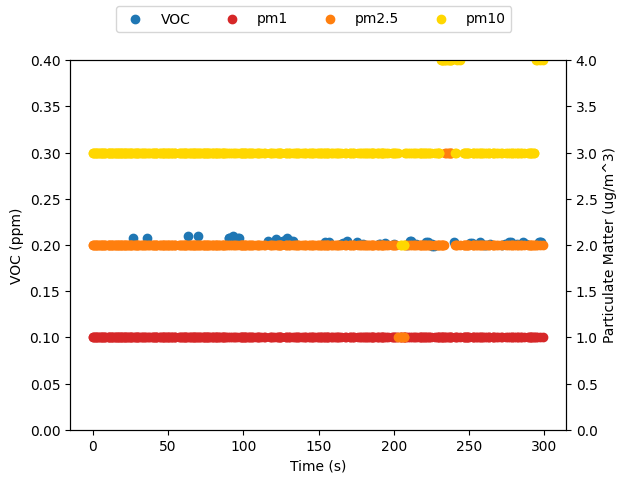

In [35]:
#| echo: false
#| label: fig-1
#| fig-cap: "Time series data of indoor VOC and PM concentrations, a 5 minute sample of BLE advertising data"

fig1, ax1 = plt.subplots()
ax1.scatter(df['Time'], df['VOC'], label="VOC")
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('VOC (ppm)')
ax1.set_ylim(0.0, 0.4)

ax1_2 = ax1.twinx()
ax1_2.scatter(df['Time'], df['PM1'], color='tab:red', label="pm1")
ax1_2.scatter(df['Time'], df['PM2.5'], color='tab:orange', label="pm2.5")
ax1_2.scatter(df['Time'], df['PM10'], color='gold', label="pm10")
ax1_2.set_ylabel('Particulate Matter (ug/m^3)')
ax1_2.set_ylim(0.0, df['PM10'].max())

fig1.legend(loc="upper center", ncols=4)

plt.show()

Plotting the timeseries data shows the PM data is very noisy -- largely because it is rounding to the nearest whole integer. I also suspect that I should be cleaning up the scan responses better. Probably a lot of those are duplicates -- it is not actually a fresh reading just rebroadcast of what had been read last. I'm not really sure.

## Logging to a CSV

If you are only collecting 5 minutes of data, reading directly into memory like this is reasonable. But probably you want to log the data over a longer stretch of time, and it makes more sense to log the data to a csv -- saving it more permanently. The following creates a new csv with the given filename then, for every valid packet processed, appends the results to the csv.

In [26]:
import csv

In [27]:
async def log_to_csv(device_mac, collection_time=600, file="atmotube.csv"):
    def adv_cb(device, advertising_data):
        if device.address == device_mac:
            row = process_adv_data((time.time(), device, advertising_data))
            if len( [ val for key, val in row.items() if val is not None ]) >1:
                # only collect results when we actually have a measurement
                with open(file, 'a', newline='') as csvfile:
                    writer = csv.DictWriter(csvfile, fieldnames=HEADERS)
                    writer.writerow(row)
        else:
            pass
        return None
    
    async def receiver(event):
        async with BleakScanner(adv_cb) as scanner:
            await event.wait()
    
    # prepare csv file
    with open(file, 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=HEADERS)
        writer.writeheader()

    # start scanning
    loop = asyncio.Event()
    task = asyncio.create_task(receiver(loop))

    # wait until the collection time is up
    await asyncio.sleep(collection_time)
    loop.set()
    _ = await asyncio.wait([task])
    
    return True

::: {.callout-warning}
The callback function is doing a lot of work and blocking to write to a csv. This is, in general, not a good idea. When I put this together, I figured that the rate of new data from the Atmotube is significantly slower than the time required to process data and write it to a csv that it would be fine, and it was, but it isn't really robust. A better solution might be to have the callback put the data into a queue and have a seperate worker process results into the csv.
:::

To get this going, I just created a csv with the current timestep in the filename -- so if I stop and start I don't clobber previous data -- and leave it to run for an hour. I just left this running in jupyter while I switched to a different desktop and went about my life, but a longer-term solution would be in a script that runs in the background.

In [28]:
import math

In [29]:
now = math.floor(time.time())
timestamped_file = f"atmotube-{now}.csv"
result = await log_to_csv(ATMOTUBE, 3600, timestamped_file)

print("Success!") if result else print("Boo")

Success!


While it is running, you can check on the progress with `tail -f %filename`, and watch the results come in live on the terminal. Once it is done, the csv can be read into pandas and plotted like before

In [30]:
logged_data = pd.read_csv(timestamped_file)

In [31]:
logged_data.describe()

,Timestamp,VOC,RH,T,P,PM1,PM2.5,PM10
count,4.823000e+03,835.000000,835.000000,835.0,835.000000,3988.0,3988.000000,3988.000000
mean,1.747676e+09,0.226522,34.810778,21.0,93.320590,1.0,1.919007,2.945587
std,1.037307e+03,0.012884,0.711420,0.0,0.018019,0.0,0.328726,0.325025
min,1.747674e+09,0.195000,34.000000,21.0,93.283000,1.0,1.000000,2.000000
25%,1.747675e+09,0.217000,34.000000,21.0,93.303000,1.0,2.000000,3.000000
50%,1.747676e+09,0.230000,35.000000,21.0,93.325000,1.0,2.000000,3.000000
75%,1.747677e+09,0.237000,35.000000,21.0,93.337000,1.0,2.000000,3.000000
max,1.747678e+09,0.249000,37.000000,21.0,93.355000,1.0,3.000000,4.000000


In [32]:
logged_data['Time'] = logged_data['Timestamp'] - logged_data.iloc[0]['Timestamp']

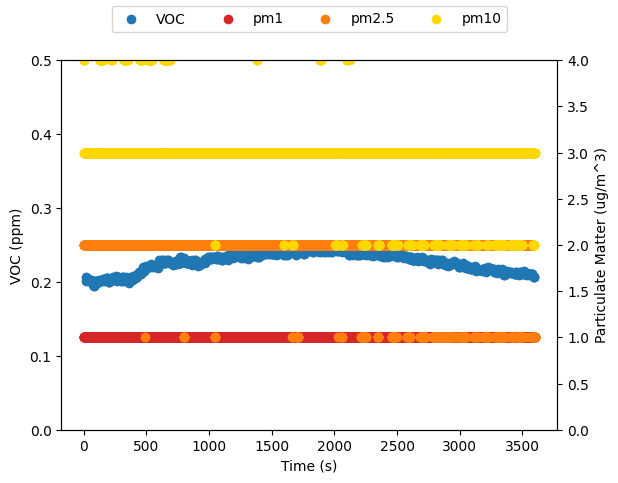

In [34]:
#| echo: false
#| label: fig-2
#| fig-cap: "Time series data of indoor VOC and PM concentrations, a 1-hr sample of BLE advertising data"


fig2, ax2 = plt.subplots()
ax2.scatter(logged_data['Time'], logged_data['VOC'], label="VOC")
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('VOC (ppm)')
ax2.set_ylim(0.0, 0.5)

ax2_2 = ax2.twinx()
ax2_2.scatter(logged_data['Time'], logged_data['PM1'], color='tab:red', label="pm1")
ax2_2.scatter(logged_data['Time'], logged_data['PM2.5'], color='tab:orange', label="pm2.5")
ax2_2.scatter(logged_data['Time'], logged_data['PM10'], color='gold', label="pm10")
ax2_2.set_ylabel('Particulate Matter (ug/m^3)')
ax2_2.set_ylim(0.0, logged_data['PM10'].max())

fig2.legend(loc="upper center", ncols=4)

plt.show()

The atmotube is also logging data to its internal memory, so I exported that and plotted it against what was broadcast.

In [37]:
export_data = pd.read_csv('atmotube-export-data.csv')
export_data.describe()

,"VOC, ppm",AQS,Air quality health index (AQHI) - Canada,"Temperature, °C","Humidity, %","Pressure, kPa","PM1, ug/m3","PM2.5, ug/m3","PM2.5 (avg 3h), ug/m3","PM10, ug/m3","PM10 (avg 3h), ug/m3",Latitude,Longitude
count,66.000000,66.000000,66.0,66.0,66.000000,66.000000,66.0,66.000000,66.000000,66.000000,66.000000,0.0,0.0
mean,0.239985,85.045455,1.0,21.0,34.484848,93.316364,1.0,1.530303,1.559175,2.545455,2.861027,NaN,NaN
std,0.018563,1.156012,0.0,0.0,0.769464,0.019817,0.0,0.502905,0.036129,0.501745,0.041909,NaN,NaN
min,0.212000,82.000000,1.0,21.0,33.000000,93.280000,1.0,1.000000,1.466667,2.000000,2.722222,NaN,NaN
25%,0.228250,85.000000,1.0,21.0,34.000000,93.300000,1.0,1.000000,1.550000,2.000000,2.866667,NaN,NaN
50%,0.238000,85.000000,1.0,21.0,34.500000,93.320000,1.0,2.000000,1.561111,3.000000,2.877778,NaN,NaN
75%,0.244750,86.000000,1.0,21.0,35.000000,93.337500,1.0,2.000000,1.583333,3.000000,2.888889,NaN,NaN
max,0.295000,87.000000,1.0,21.0,36.000000,93.350000,1.0,2.000000,1.616667,3.000000,2.888889,NaN,NaN


In [36]:
from datetime import datetime

In [38]:
export_data['Timestamp'] = export_data[['Date']].apply(
    lambda str: datetime.strptime(str.iloc[0], "%Y/%m/%d %H:%M:%S").timestamp(), axis=1)

In [39]:
export_data['Time'] = export_data['Timestamp'] - logged_data.iloc[0]['Timestamp']

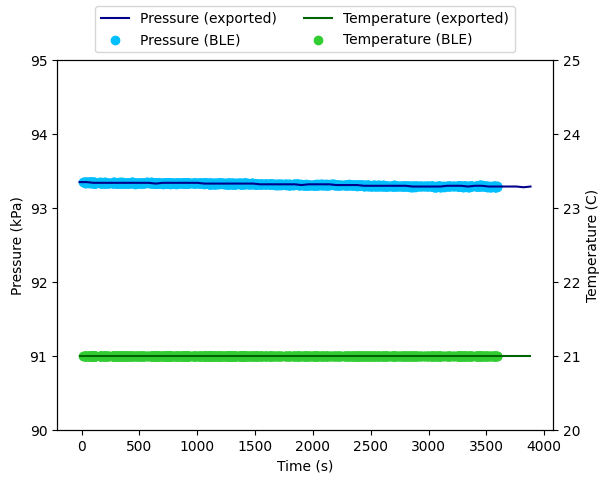

In [57]:
#| echo: false
#| label: fig-5
#| fig-cap: " Time series data of indoor temperature and pressure, a 1-hr sample of BLE advertising data and data exported from the Atmotube app"

fig5, ax5 = plt.subplots()
ax5.plot(export_data['Time'], export_data['Pressure, kPa'], color='darkblue', label="Pressure (exported)")
ax5.scatter(logged_data['Time'], logged_data['P'], color='deepskyblue', label="Pressure (BLE)")
ax5.set_xlabel('Time (s)')
ax5.set_ylabel('Pressure (kPa)')
ax5.set_ylim(90.0, 95.0)

ax5_2 = ax5.twinx()
ax5_2.plot(export_data['Time'], export_data['Temperature, °C'], color='darkgreen', label="Temperature (exported)")
ax5_2.scatter(logged_data['Time'], logged_data['T'], color='limegreen', label="Temperature (BLE)")
ax5_2.set_xlabel('Time (s)')
ax5_2.set_ylabel('Temperature (C)')
ax5_2.set_ylim(20.0, 25.0)

fig5.legend(loc="upper center", ncols=2)

plt.show()

The basic atmospheric data like temperature, pressure, and relative humidity appear to be the same. But there is something weird going on with the VOC measurements.

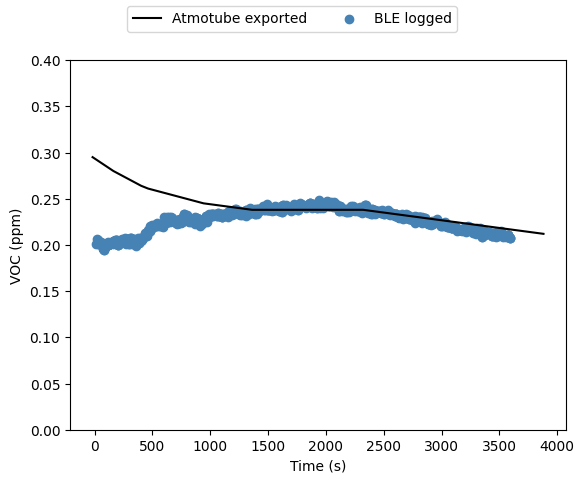

In [41]:
#| echo: false
#| label: fig-3
#| fig-cap: "Time series data of indoor VOC concentrations, a 1-hr sample of BLE advertising data and data exported from the Atmotube app"


fig3, ax3 = plt.subplots()
ax3.plot(export_data['Time'], export_data['VOC, ppm'], color='black', label="Atmotube exported")
ax3.scatter(logged_data['Time'], logged_data['VOC'], color='steelblue', label="BLE logged")
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('VOC (ppm)')
ax3.set_ylim(0.0, 0.4)

fig3.legend(loc="upper center", ncols=2)

plt.show()

I *think* the atmotube is actually exporting the rolling average of the VOC results over a fairly broad window, whereas the broadcast reading is more direct from the sensor. I would have to run this for much longer to see if that's the case.

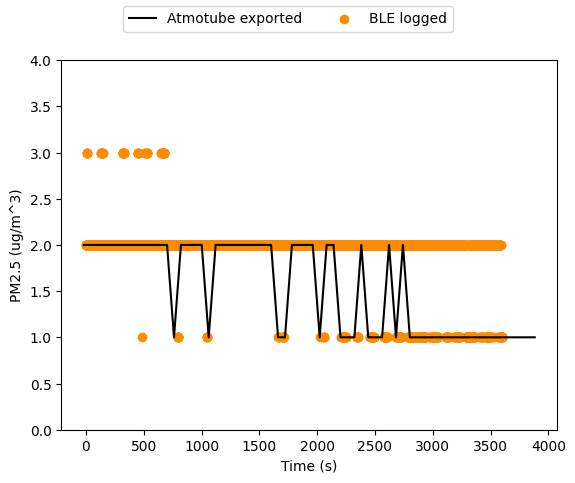

In [42]:
#| echo: false
#| label: fig-4
#| fig-cap: "Time series data of indoor PM2.5 concentrations, a 1-hr sample of BLE advertising data and data exported from the Atmotube app"


fig4, ax4 = plt.subplots()
ax4.plot(export_data['Time'], export_data['PM2.5, ug/m3'], color='black', label="Atmotube exported")
ax4.scatter(logged_data['Time'], logged_data['PM2.5'], color='darkorange', label="BLE logged")
ax4.set_xlabel('Time (s)')
ax4.set_ylabel('PM2.5 (ug/m^3)')
ax4.set_ylim(0.0, 4.0)

fig4.legend(loc="upper center", ncols=2)

plt.show()

The PM data shows the results are closer, but still have issues. The exported data is (I believe) a by-the-minute average, rounded to the nearest integer. There is a single data point for each minute in the dataset, giving 66 overall. Whereas the raw PM broadcast data has 3988 data points, and I think most of those are just rebroadcasts and are not "real".

One thing I was thinking of doing was to capture only the first scan response packet after an advertising packet then ignore all the rest until the next advertising packet. I have also been ignoring the info flags since, when I was just noodling around, they didn't seem to change at all (with the device always sampling), they might actually be telling me things that I've been ignoring.

## Final Thoughts

Hopefully this helps you get set-up collecting data from your atmotube (I don't know why else you would read this far). From here to building a simple dashboard or datalogger should be an easy weekend project. I think for applications where you want higher fidelity data over a long stretch of time, periodically requesting data using GATT makes the most sense. The PM data comes with more decimal places of precision, and you don't need it more frequently than every minute or so.

The BLE advertising data could be an easy way of building a passive dashboard, continuously listening and updating the air quality statistics. Though some effort would need to be put in cleaning up the data, or perhaps just presenting a rolling average of some kind to smooth out the noise.

There is also a whole section of the documentation on connecting to an atmotube and downloading data from it, which I didn't bother to investigate. It looked overly complicated for what I wanted to do. If you figure that out, please let me know!

## Update

I was thinking about this more and there was one avenue I neglected to explore: subscribing to GATT notifications from the atmotube. Instead of requesting a single data point, like I did above, one can subscribe to the feed and the atmotube will just send packets whenever an update occurs. That is what I do below.

To get started I decided to make cytpe structs for each of the bytestrings that can be returned. I don't think this is necessary, but I like how it seperates the logic of decoding the response on an aesthetic level. It also makes it very clear how the bytestrings are structured.

In [4]:
from ctypes import LittleEndianStructure, c_ubyte, c_byte, c_short, c_int

class StatusData(LittleEndianStructure):
    _fields_ = [
                ("pm_sensor",          c_ubyte, 1),
                ("error",              c_ubyte, 1),
                ("bonding",            c_ubyte, 1),
                ("charging",           c_ubyte, 1),
                ("charging_timer",     c_ubyte, 1),
                ("_bit_6",             c_ubyte, 1),
                ("sgpc3_pre_heating",  c_ubyte, 1),
                ("_bit_8",             c_ubyte, 1),
                ("battery_level",      c_ubyte, 8),
    ]

    def __new__(cls, ts, data):
        return cls.from_buffer_copy(data)

    def __init__(self, ts, data):
        self.timestamp = ts

In [5]:
class SPS30Data(LittleEndianStructure):
    _fields_ = [
		('_pm1',   c_byte*3),
		('_pm2_5', c_byte*3),
		('_pm10',  c_byte*3),
		('_pm4',   c_byte*3), 
    ]
    _pack_ = 1

    def __new__(cls, ts, data):
        return cls.from_buffer_copy(data)

    def __init__(self, ts, data):
        self.timestamp = ts

    @property
    def pm1(self):
        res = int.from_bytes(self._pm1, 'little', signed=True)
        return res/100 if res > 0 else None

    @property
    def pm2_5(self):
        res = int.from_bytes(self._pm2_5, 'little', signed=True)
        return res/100 if res > 0 else None

    @property
    def pm10(self):
        res = int.from_bytes(self._pm10, 'little', signed=True)
        return res/100 if res > 0 else None

In [6]:
class BME280Data(LittleEndianStructure):
    _fields_ = [
        ('_rh',    c_byte),
        ('_T',     c_byte),
        ('_P',     c_int),
        ('_T_dec', c_short),
        ]
    _pack_ = 1

    def __new__(cls, ts, data):
        return cls.from_buffer_copy(data)

    def __init__(self, ts, data):
        self.timestamp = ts
   
    @property
    def RH(self):
        return self._rh

    @property
    def T(self):
        return self._T_dec/100

    @property
    def P(self):
        return self._P/1000

In [7]:
class SGPC3Data(LittleEndianStructure):
    _fields_ = [
        ('_TVOC',    c_short),
        ]
    _pack_ = 1

    def __new__(cls, ts, data):
        return cls.from_buffer_copy(data)

    def __init__(self, ts, data):
        self.timestamp = ts

    @property
    def TVOC(self):
        return self._TVOC/1000

With that out of the way, there are two other components I need for this to work: a collector which will collect all of the data sent back from the atmotube and a worker which will log it to a csv. Unlike above, where I logged each advertising packet as I came in, I am going to make these run asynchronously using `asyncio`. I think this is what really *should* be done, instead of blocking for file i/o every time a callback function is triggered.

To make this happen I largely copied [what was done in this example](https://github.com/hbldh/bleak/blob/develop/examples/async_callback_with_queue.py) which uses an async queue to pass data between the two workers. The basic idea is:

1. The collector starts up and scans for the atmotube, by MAC address.
2. When it finds the device it requests notifications for one of the GATT characteristics, in this case I am requesting the status data and the SPS30 data, which contains the pm concentrations.
3. The collector then waits around for the `collection_time` and every time it gets a new set of data uses the callbacks `status_cb` and `sps30_cb` to process the bytestring and put the result on the queue

In [8]:
async def collect_data(mac, queue, collection_time):
    async def status_cb(char, data):
        ts = time.time()
        res = StatusData(ts, data)
        await queue.put(res)

    async def sps30_cb(char, data):
        ts = time.time()
        res = SPS30Data(ts, data)
        await queue.put(res)
    
    device = await BleakScanner.find_device_by_address(mac)
    if not device:
        raise Exception("Device not found")
    
    async with BleakClient(device) as client:
        # start notifications
        await client.start_notify(STATUS_UUID, status_cb)
        await client.start_notify(SPS30_UUID, sps30_cb)

        # wait for collection period to end
        await asyncio.sleep(collection_time)

        # signals end of queue
        await queue.put(None)

Concurrently with that, a logger needs to write things to a csv. The basic idea is this:

1. When the logger starts it creates a new csv file with the given `filename`, and writes the column headers.
2. The worker waits for data to appear on the queue and, once it does, takes it out (first in first out).
3. The result on the queue is lined up to the right columns in the csv, I check for the attribute `battery_level` as a lazy check of which type of result it is.
4. Finally the worker writes the result as new row on the csv.
5. If the result is `None`, that is a signal that the collector has finished and the loop exits.
6. Regardless, once the logger has processed the data from the queue, it calls `task_done()` to notify the queue of this and the loop begins again.

In [9]:
import csv

In [10]:
HEADERS = ["Timestamp", "PM Sensor", "PM1", "PM2.5", "PM10"]

In [11]:
async def write_row(filename,row):
    async with aiofiles.open(filename, 'a', newline='') as csvfile:
        writer = aiocsv.AsyncDictWriter(csvfile, fieldnames=HEADERS)
        await writer.writerow(row)

In [12]:
async def log_to_csv(filename, queue):
    # prepare csv file
    async with aiofiles.open(filename, 'w', newline='') as csvfile:
        writer = aiocsv.AsyncDictWriter(csvfile, fieldnames=HEADERS)
        await writer.writeheader()

    # log data from queue
    flag = True
    while flag:
        result = await queue.get()
        if result is not None:
            # we have some data to write
            row = dict.fromkeys(HEADERS)
            row["Timestamp"] = result.timestamp
            if hasattr(result, "battery_level"):
                # we have a status type
                row["PM Sensor"] = result.pm_sensor
            else:
                # we have pm data
                row["PM1"] = result.pm1
                row["PM2.5"] = result.pm2_5
                row["PM10"] = result.pm10

            await write_row(filename,row)
        else:
            # the end of the queue
            flag = False
        queue.task_done()

My first attempt at this I put the `while` loop inside the `with` block, so the whole thing ran inside the file context manager. This had the effect of nothing actually being written to the csv until the `with` block exited and the file closed. It took me a long time to realize *that* is what was happening, since it looked exactly the same as the two processes running sequentially: collect all the data *and then* write it all to csv.

In this version, every time a row is added to the csv the file is opened, a line is written, and then it is closed. There is probably a way of holding it open while logging, but that might make things more complicated since a whole bunch of new logic would be needed to catch any exceptions and ensure that the file is closed properly -- something that happens behind the scenes with a simple `with` block.

Finally, I put it all together with a simple sequence of tasks:

1. Create an empty asyncio `Queue`
2. Start the logger, the worker that logs results to the csv
3. Start the collector, the worker that collects packets from the atmotube
4. Wait for the collector to finish, then close.

In [14]:
async def save_data(mac, csv, collection_time):
    q = asyncio.Queue()
    
    logger = asyncio.create_task(log_to_csv(csv, q))
    collector = asyncio.ensure_future(collect_data(mac, q, collection_time))
    
    await collector

I ran this for an hour in the background as a test and it seems to work fine.

```python
await save_data(ATMOTUBE, f"atmotube-{math.floor(time.time())}.csv", 3600)
```

In [24]:
df = pd.read_csv("atmotube-1748482080.csv")

In [26]:
df['Time'] = df['Timestamp'] - df.iloc[0]['Timestamp']

In [29]:
df.head()

,Timestamp,PM Sensor,PM1,PM2.5,PM10,Time
0,1.748482e+09,NaN,10.92,13.43,14.97,0.000000
1,1.748482e+09,NaN,10.93,13.03,14.66,2.610108
2,1.748482e+09,NaN,11.05,13.42,15.19,5.220881
3,1.748482e+09,NaN,11.35,13.75,15.34,7.784888
4,1.748482e+09,NaN,11.59,14.13,15.50,10.395001


In [18]:
#| echo: false
from matplotlib import pyplot as plt

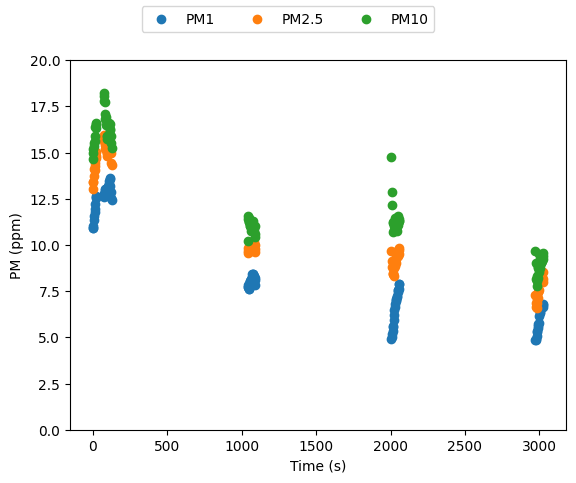

In [23]:
#| echo: false
#| label: fig-6
#| fig-cap: "Time series data of indoor PM2.5 concentrations, a 1-hr sample using GATT notifications"


fig5, ax5 = plt.subplots()
ax5.scatter(df['Time'], df['PM1'], label="PM1")
ax5.scatter(df['Time'], df['PM2.5'], label="PM2.5")
ax5.scatter(df['Time'], df['PM10'], label="PM10")
ax5.set_xlabel('Time (s)')
ax5.set_ylabel('PM (ppm)')
ax5.set_ylim(0.0, 20.0)

fig5.legend(loc="upper center", ncols=3)

plt.show()

With no context it looks like something is horribly wrong, what are all those gaps in the data? My atmotube is set to only sample every 15 minutes, this is usually how I leave it to save on battery. This also explains some of the weirdness with the data, why does each sample start with a rapidly increasing concentration before levelling out? The atmotube is returning data right when the sampling fan has just turned on; this is not yet an accurate sample of the ambient air, it is the stagnant air inside the atmotube. This is a much more obvious problem with VOC data, it is clearly visible on the app as a funky saw-tooth wave where the VOC concentration plunges whenever the fan starts and, once it stops, slowly creeps up. It is an artifact of how the atmotube is sampling the air, not of how the data is being collected.

If the atmotube is set to always on mode, these artifacts go away, but if you want to monitor it in other configurations it is worth considering how the data should be cleaned up. For example watching for the `pm_sensor` flag to turn on then throwing out the first ~30s of pm data before looking at the rest. The GATT notifications make it very clear when the atmotube is sampling and when it isn't. There will be a notification that `pm_sensor` has turned from 0 to 1, then data will start arriving with pm data, then a notification that the `pm_sensor` has turned from 1 to 0, followed by an empty row of pm data. See a snipped of the csv below. Note that `pm_sensor` values and actual pm values are always on seperate rows.

In [28]:
df[36:42]

,Timestamp,PM Sensor,PM1,PM2.5,PM10,Time
36,1.748482e+09,NaN,12.42,14.34,15.23,127.802146
37,1.748482e+09,0.0,NaN,NaN,NaN,130.322095
38,1.748482e+09,NaN,NaN,NaN,NaN,130.322191
39,1.748483e+09,1.0,NaN,NaN,NaN,1035.107224
40,1.748483e+09,NaN,7.74,9.55,10.21,1040.146906
41,1.748483e+09,NaN,7.81,9.82,11.40,1042.621936


In addition to some data-wrangling, there are some other obvious upgrades to my code before it would be ready to deploy in an app. For one, there is minimal error handling. Any malformed bytestrings returned by the atmotube will throw an exception and kill everything. Additionally there are no checks to maintain a connection to the atmotube. It would simply timeout, having collected nothing. If you were planning on running this passively for a long period of time, unattended, that could be a big deal.